# RNN model for Natural Language Processing with Disaster Tweets

This project is related to the Keggle competition "Natural Language Processing with Disaster Tweets". All information about the dataset and the competion can be found here: https://www.kaggle.com/competitions/nlp-getting-started.

The objective is to build a machine learning model that predicts which Tweets are about real disasters. 

Tha dataset consists of 7613 samples containing the "text" of a tweet, A "keyword" from that tweet (might be blank!) as well as the location the tweet was sent from (might be blank).
"target" is the label with 1 menas the tweet is about a disaster and 0 means it is not.

In [2]:
# installing libraries

#%pip install pandas
#%pip install numpy
#!pip install matplotlib
#%pip install -U scikit-learn
#%pip install seaborn
#%pip install tensorflow
#%pip install plotly
#%pip install tqdm

In [3]:
# importing ibraries

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.regularizers import l2
from keras.callbacks import EarlyStopping
import pandas as pd
import numpy as np
import seaborn as sns
from tensorflow.keras.optimizers import Adam


2024-02-16 21:20:52.287049: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-16 21:20:52.648776: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-16 21:20:52.648855: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-16 21:20:52.716913: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-16 21:20:52.864369: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-16 21:20:52.866205: I tensorflow/core/platform/cpu_feature_guard.cc:1

--------
Data Cleaning & Exploratory data analysis
-----------

In [4]:
# read training data and printing some smaples
train_df = pd.read_csv('train.csv')
train_df.sample(5)

,id,keyword,location,text,target
2712,3896,detonation,NaN,Ignition Knock (Detonation) Sensor-Senso Stand...,0
58,82,ablaze,hollywoodland,They sky was ablaze tonight in Los Angeles. I'...,0
4486,6382,hostages,china,#hot C-130 specially modified to land in a st...,1
6981,10012,twister,"Las Vegas, NV",950. If a landslide tumbles down todayI'm on y...,1
7289,10430,whirlwind,"pettyville, usa",this week has been a whirlwind but this is ex...,0


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


As mentioned there are 7613 samples with null values in location and keyword

Removing duplicates (if 'text' belongs to the same 'target')

In [6]:
train_df = train_df.drop_duplicates(subset=['target', 'text'], keep='last')
# number of remaining samples
train_df.shape

(7521, 5)

target
0    57.4
1    42.6
Name: proportion, dtype: float64


([<matplotlib.patches.Wedge at 0x7f393ca4d720>,
 [Text(-0.25250987371631217, 1.0706254077294133, 'Non-disaster'),
  Text(0.2525098737163125, -1.070625407729413, 'Disaster')])

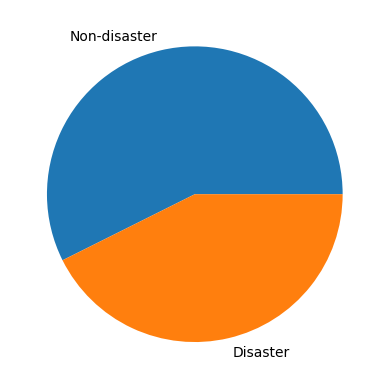

In [7]:
# percentage of non-disaster (label 0) vs disaster (label 1)
print(round(train_df['target'].value_counts(normalize=True) * 100, 1))

# visualizing the percentage of each class
labels = 'Non-disaster', 'Disaster'
sizes = train_df['target'].value_counts(normalize=True) * 100

fig, ax = plt.subplots()
ax.pie(sizes, labels=labels)


We see that around 57% of the training data are non-disaster  and 43% disaster (relatively balanced)

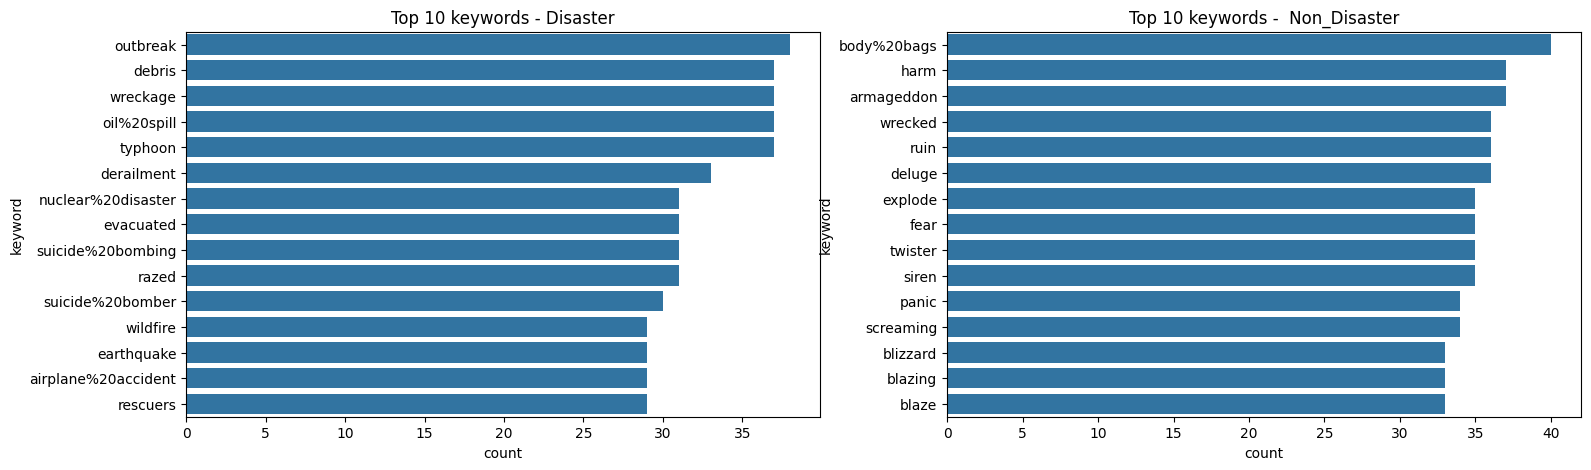

In [8]:
# plotting the top 10 keyword in each category
plt.figure(figsize=(18,5))
plt.subplot(121)
plt.title('Top 10 keywords - Disaster')
sns.barplot(y=train_df.loc[train_df['target']==1]['keyword'].value_counts()[:15].index,x=train_df.loc[train_df['target']==1]['keyword'].value_counts()[:15])
plt.subplot(122)
plt.title('Top 10 keywords -  Non_Disaster')
sns.barplot(y=train_df.loc[train_df['target']==0]['keyword'].value_counts()[:15].index,x=train_df.loc[train_df['target']==0]['keyword'].value_counts()[:15])
plt.show()

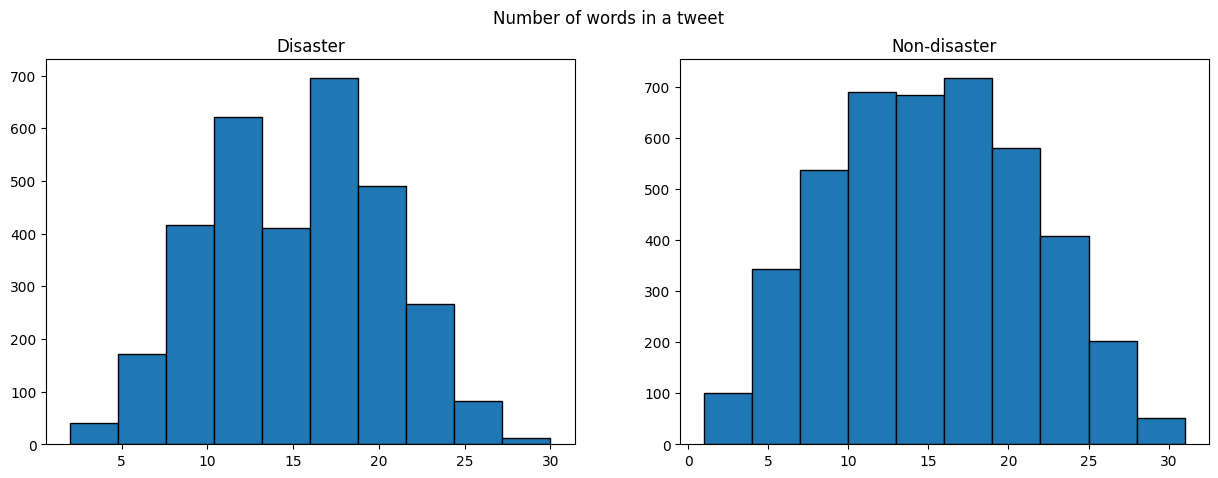

In [9]:
# plotting the histogram of number of words in each tweet for each category
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
train_disaster = train_df[train_df['target']==1]['text'].str.split().map(lambda x: len(x))
ax1.hist(train_disaster, ec="black")
ax1.set_title('Disaster')

train_nondisaster = train_df[train_df['target']==0]['text'].str.split().map(lambda x: len(x))
ax2.hist(train_nondisaster,  ec="black")
ax2.set_title('Non-disaster')
fig.suptitle('Number of words in a tweet')
plt.show()

there is no sgnificant difference between the two histogram

In [10]:
# spliting data to train (80%) and validate (20%)

X_train, X_test, y_train, y_test = train_test_split(train_df['text'], train_df['target'], test_size=0.2, random_state=42)
print(X_train.shape)
print(X_test.shape)

(6016,)
(1505,)


-------------
Text preprocessing
------------

Preprocessing steps:
- Tokenizing the tweets: split the input text ot individual tokens
- converting the data to sequence of integers: such that each token in the input is replaced by its correesponding interger index
- Padding and truncation: to make sure the seuence have uniform lenght

In [11]:
num_timesteps = 50
trunc_type='post'

# number of words in the vocabulay
word_num = 10000

# Tokenization
tokenizer = Tokenizer(num_words = word_num, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

# word_index = tokenizer.word_index
train_sequence = tokenizer.texts_to_sequences(X_train)
test_sequence = tokenizer.texts_to_sequences(X_test)

# truncating/padding
train_padded = pad_sequences(train_sequence, maxlen=num_timesteps, truncating=trunc_type)
test_padded = pad_sequences(test_sequence, maxlen=num_timesteps)

In [12]:
# print shape of padded data
print(f'Train padded shape: {train_padded.shape}')
print(f'Test padded shape: {test_padded.shape}')

Train padded shape: (6016, 50)
Test padded shape: (1505, 50)


------------
RNN LSTM Model
------------

As the first architecture I try a simple LSTM model: 
- one emabedding layer of size 64
- one LTSM layer of size 64 
- one dense layer of size 64 (relu activation fuction)
- one output layer of size 1 (sigmoid activation fuction)

compiling the model with Adam (learning rate of 0.0001) and accuracy as metric

In [13]:
# Model with LSTM
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(word_num, 64),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(Adam(learning_rate=0.0001), loss='binary_crossentropy',metrics=['accuracy'])
model.summary()

num_epochs = 10
history_lstm = model.fit(train_padded, y_train, epochs=num_epochs, validation_data=(test_padded, y_test))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 64)          640000    
                                                                 
 lstm (LSTM)                 (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 677249 (2.58 MB)
Trainable params: 677249 (2.58 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
188/188 [==============================] - 8s 32ms/step - loss: 0.6780 - accuracy: 0.5705 - val_loss: 0.6561 - val_accuracy: 0.5821
Epoch 2/1

In [14]:
# function to plot the training and validation accuracy:

def plot_accu(history, title):
    acc_t = history.history['accuracy']
    acc_v = history.history['val_accuracy']

    x_axis = range(1, len(acc_t) + 1)

    plt.plot(x_axis, acc_t, label='Training accuracy')
    plt.plot(x_axis, acc_v, label='Validation accuracy')
    plt.title(title)
    plt.legend()
    plt.figure()

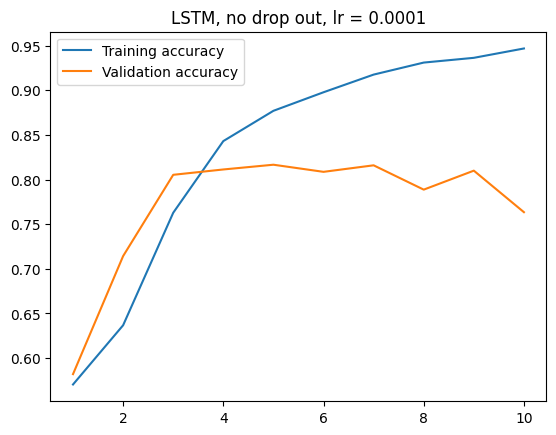

<Figure size 640x480 with 0 Axes>

In [15]:
title = 'LSTM, no drop out, lr = 0.0001'
plot_accu(history_lstm, title)

Whie the training accuracy reaches 0.96 the validation accuracy remains around 0.8 which might indicate an overfitting issue

Hyperparameter tuning and model architecture modification
------------

First I add dropout and recurrent_drouput of 0.5 to the architecture

In [16]:
# Model with LSTM and drouput
model2 = tf.keras.Sequential([
    tf.keras.layers.Embedding(word_num, 64),
    tf.keras.layers.LSTM(64, dropout=0.5, recurrent_dropout=0.5),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model2.compile(Adam(learning_rate=0.0001), loss='binary_crossentropy',metrics=['accuracy'])
model2.summary()

num_epochs = 20
history_lstm2 = model2.fit(train_padded, y_train, epochs=num_epochs, validation_data=(test_padded, y_test))

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 64)          640000    
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 677249 (2.58 MB)
Trainable params: 677249 (2.58 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/20
188/188 [==============================] - 11s 50ms/step - loss: 0.6826 - accuracy: 0.5613 - val_loss: 0.6591 - val_accuracy: 0.5807
Epoch 

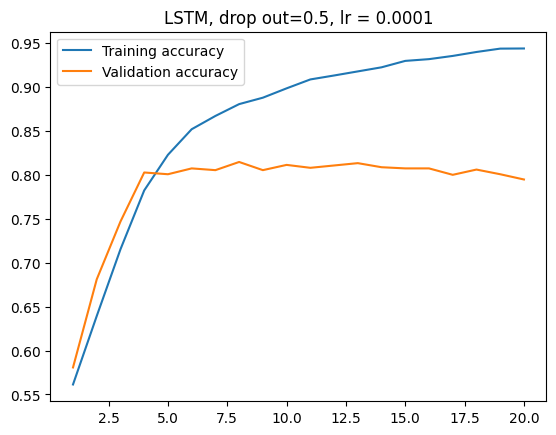

<Figure size 640x480 with 0 Axes>

In [17]:
# plot the accuracy:
title = 'LSTM, drop out=0.5, lr = 0.0001'
plot_accu(history_lstm2, title)

The results did not improve significantly

After I modify the vectorization step to increase the number of words to 20000 (same model with drouput=0.5)

In [18]:

num_timesteps2 = 50
trunc_type='post'
word_num2 = 20000

# Tokenization
tokenizer2 = Tokenizer(num_words = word_num2, oov_token="<OOV>")
tokenizer2.fit_on_texts(X_train)

# word_index = tokenizer.word_index
train_sequence2 = tokenizer2.texts_to_sequences(X_train)
test_sequence2 = tokenizer2.texts_to_sequences(X_test)

# # truncating/padding
train_padded2 = pad_sequences(train_sequence2, maxlen=num_timesteps2, truncating=trunc_type)
test_padded2 = pad_sequences(test_sequence2, maxlen=num_timesteps2)

In [19]:
model3 = tf.keras.Sequential([
    tf.keras.layers.Embedding(word_num2, 64),
    tf.keras.layers.LSTM(64, dropout=0.5, recurrent_dropout=0.5),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model3.compile(Adam(learning_rate=0.0001), loss='binary_crossentropy',metrics=['accuracy'])
model3.summary()

num_epochs = 20
history_lstm3 = model3.fit(train_padded2, y_train, epochs=num_epochs, validation_data=(test_padded2, y_test))

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 64)          1280000   
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dense_4 (Dense)             (None, 64)                4160      
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1317249 (5.02 MB)
Trainable params: 1317249 (5.02 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/20
188/188 [==============================] - 14s 65ms/step - loss: 0.6835 - accuracy: 0.5622 - val_loss: 0.6652 - val_accuracy: 0.5807
Epoc

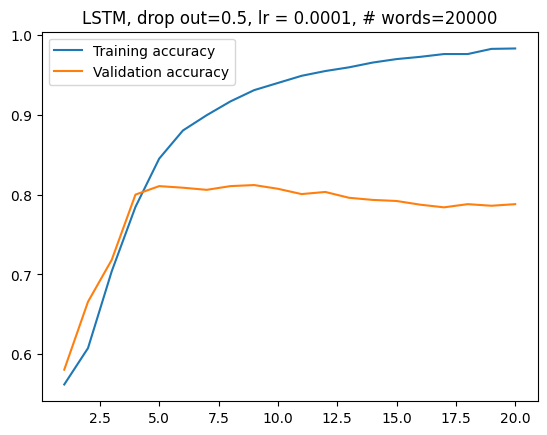

<Figure size 640x480 with 0 Axes>

In [20]:
# plot the accuracy:
title = 'LSTM, drop out=0.5, lr = 0.0001, # words=20000'
plot_accu(history_lstm3, title)

the results did not improve significantly

After I use l2 regularization and reduce the leaning rate. In addition I use early stopping to stop when the validation accuracy is decreasing and I keep the best weights

In [47]:
model4 = tf.keras.Sequential([
    tf.keras.layers.Embedding(word_num, 64),
    tf.keras.layers.LSTM(64, dropout=0.5, recurrent_dropout=0.5, kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model4.compile(Adam(learning_rate=0.00005), loss='binary_crossentropy',metrics=['accuracy'])
model4.summary()

# Define early stopping callback and keeping the best weights
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


num_epochs = 30
history_lstm4 = model4.fit(train_padded, y_train, epochs=num_epochs, validation_data=(test_padded, y_test), callbacks=[early_stopping])

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, None, 64)          640000    
                                                                 
 lstm_7 (LSTM)               (None, 64)                33024     
                                                                 
 dense_15 (Dense)            (None, 64)                4160      
                                                                 
 dense_16 (Dense)            (None, 1)                 65        
                                                                 
Total params: 677249 (2.58 MB)
Trainable params: 677249 (2.58 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/30
188/188 [==============================] - 7s 29ms/step - loss: 2.1847 - accuracy: 0.5640 - val_loss: 2.0222 - val_accuracy: 0.5807
Epoch 2

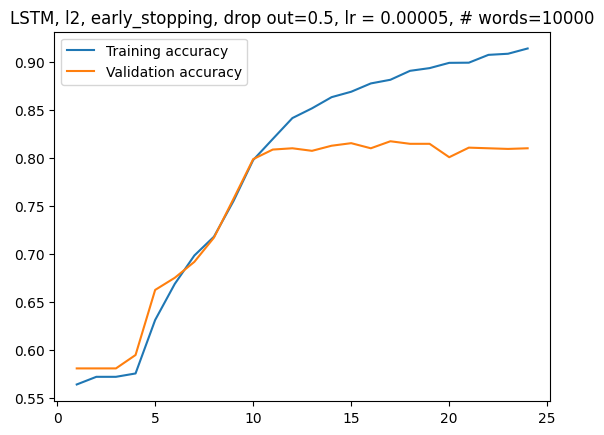

<Figure size 640x480 with 0 Axes>

In [48]:
# plot the accuracy:

title = 'LSTM, l2, early_stopping, drop out=0.5, lr = 0.00005, # words=10000'
plot_accu(history_lstm4, title)

---------
Prediction & Submission
----------

For the prediction I use the last model (model4: where I kept the best weights) for the submission.

In [50]:
# reading submission file
sample_submission = pd.read_csv("sample_submission.csv")
sample_submission.head()

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


In [51]:
# reading test dataframe
test_df = pd.read_csv("test.csv")
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [71]:
test_df.shape

(3263, 4)

Tokenizing and padding the test dataset

In [53]:

test_df_sequence = tokenizer.texts_to_sequences(test_df['text'])

# # truncating/padding
test_df_padded = pad_sequences(test_df_sequence, maxlen=num_timesteps)

In [54]:
test_df_padded.shape

(3263, 50)

In [55]:
# using model4 for prediction
# converting the outcome of sigmoid acitivation function (last layer) to 0 and 1
sample_submission["target"] = np.where(model4.predict(test_df_padded)>= 0.5, 1, 0)

102/102 [==============================] - 1s 7ms/step


In [57]:
sample_submission.to_csv("submission.csv", index=False)

----------------------
Conclusion
-----------------------

| Model | learning rate  | dropout factor |# words|regularization on LSTM layer|early stopping| train accu. (last/best) | valid accu.(last/best)|
| --- | ---   |--- | --- |--- |--- |--- |--- |
| 1| 0.0001  |0.0 |10000|-| no |0.947| 0.763 |
| 2| 0.0001  |0.5 |10000| -| no |0.944 |0.795 |
| 3| 0.0001  |0.5 | 20000|-| no |0.983 |0.789 |
| 4| 0.00005  |0.5 | 10000|l2| yes |0.881 |0.817 |

Above is a table comparison of different models.

Based on these results I decided to predict the test data using the last model. Below is the result of the submission:
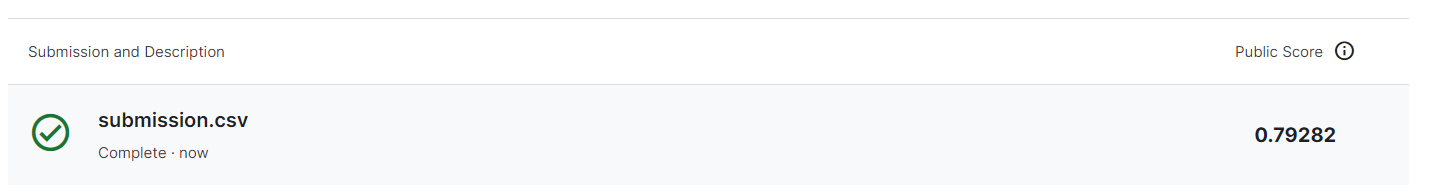
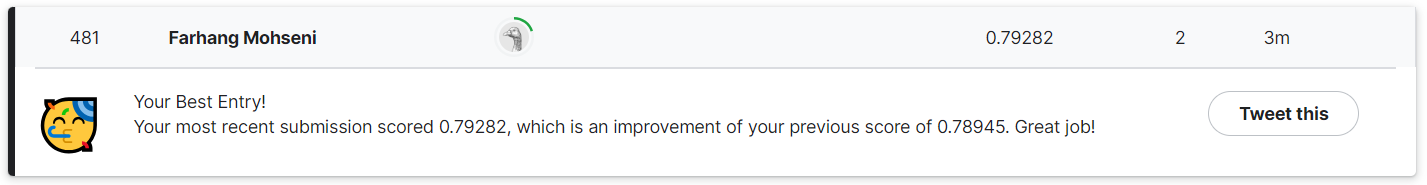

Unfortunately, the hyperparameter tuning and the model architectures that I have tested did not significantly improve the validation acuuracy compared to the first model. 
As a next step, one can try to further clean the data by removing puctuation and having only lower case, ...

